### Integration with a quantum circuit and automatic differentiation

In this tutorial we exploit the automatic differentiation of our quantum model with respect to the input data to perform the calculation of integrals.

---

The core idea is inspired by [J. M. Cruz-Martinez et al.](https://iopscience.iop.org/article/10.1088/2058-9565/ad5866) and consists in training the derivative of a quantum circuit output w.r.t. input data to approximate the integrand function of a target integration problem. Once the derivative of the circuit is trained to approximate the integrand, then the original circuit can be used to compute any definite integral value by applying the fundamental theorem of the integral calculus.

$$ I = \int g(x) dx $$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, hamiltonians, set_backend, construct_backend

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

2025-03-26 11:59:02.948362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742986742.967336  120630 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742986742.973096  120630 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We consider a dummy 1-dimensional target here.

In [2]:
def integrand_function(x):
    return 1/2*x + torch.sin(3 * x)

def integral_function(x):
    return x ** 2 / 4 - torch.cos(3 * x)/3 

def definite_integral(xa, xb):
    return integral_function(xb) - integral_function(xa)

npoints = 50
nqubits = 1
nlayers = 5

In [3]:
x = torch.linspace(0, 2, npoints)
g = integrand_function(x)
I = integral_function(x)

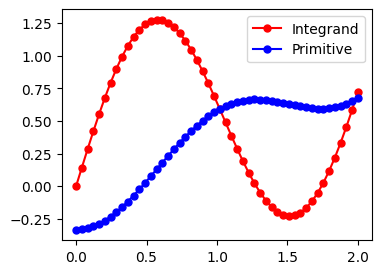

In [4]:
plt.figure(figsize=(4, 3))
plt.plot(x, g, label="Integrand", c="red", marker=".", markersize=10)
plt.plot(x, I, label="Primitive", c="blue", marker=".", markersize=10)
plt.legend()
plt.show()

Then we use a data reuploading strategy to upload the data into a quantum circuit, alternating data-encoding gates with trainable blocks of gates in our circuit. 

[Qibo 0.2.17|INFO|2025-03-26 11:59:28]: Using qiboml (pytorch) backend on cpu


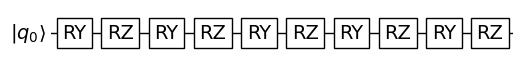

In [8]:
x_train = torch.linspace(0., 2., npoints, dtype=torch.float32).unsqueeze(1)
x_train = x_train.clone().detach().requires_grad_(True)
y_train = integrand_function(x_train)

set_backend("qiboml", platform="pytorch")


# Encoding layer
encoding_circ = PhaseEncoding(
    nqubits=nqubits, 
    encoding_gate=gates.RX
)

# Trainable layer
def trainable_circuit(entanglement=True):
    trainable_circ  = Circuit(nqubits)
    for q in range(nqubits):
        trainable_circ.add(gates.RY(q=q, theta=np.random.randn()))
        trainable_circ.add(gates.RZ(q=q, theta=np.random.randn()))
    if nqubits > 1 and entanglement:
        [trainable_circ.add(gates.CNOT(q%nqubits, (q+1)%nqubits) for q in range(nqubits))]
    return trainable_circ

# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits, 
    backend=construct_backend("qiboml", platform="pytorch")
    # backend=construct_backend("numpy")
)

circuit_structure = []
for _ in range(nlayers):
    circuit_structure.extend(
        [encoding_circ, trainable_circuit(entanglement=True)]
    )

# The whole model
model = QuantumModel(
    circuit_structure=circuit_structure,
    decoding=decoding_circ,
    # differentiation=Jax()
)

model.draw()

optimizer = optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.99))
criterion = nn.MSELoss()

def prediction(model, x_i):
    y_pred = model(x_i)
    dydx = torch.autograd.grad(
        outputs=y_pred,
        inputs=x_i,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True,
        retain_graph=True,
        allow_unused=True,
    )[0]
    return dydx

def loss_function(model, x, target):
    losses = []
    # Process each sample separately.
    for x_i, target_i in zip(x, target):
        # x_i and target_i are single samples (with proper shape)
        dydx = prediction(model, x_i)
        losses.append(criterion(dydx, target_i.unsqueeze(0)))
    return torch.stack(losses).mean()


We have a look to a first random guess of our model.

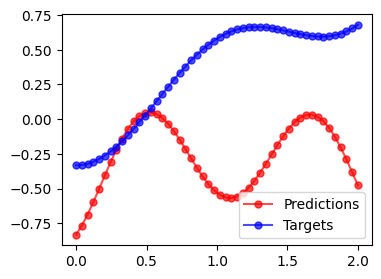

In [9]:
y_pred = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train.detach().numpy(), 
    y_pred.detach().numpy(), 
    marker=".",
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x, 
    I,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()

### Model training

In [10]:
for epoch in range(200):
    optimizer.zero_grad()
    
    # Compute loss using the wrapped loss function
    loss = loss_function(model, x_train, y_train)
    
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

Epoch 0: Loss = 2.9960052967071533
Epoch 5: Loss = 0.29667338728904724
Epoch 10: Loss = 0.3784434497356415
Epoch 15: Loss = 0.031025344505906105
Epoch 20: Loss = 0.15777944028377533
Epoch 25: Loss = 0.0911744236946106
Epoch 30: Loss = 0.009498072788119316
Epoch 35: Loss = 0.03331763669848442
Epoch 40: Loss = 0.01117367297410965
Epoch 45: Loss = 0.009015224874019623
Epoch 50: Loss = 0.008951004594564438
Epoch 55: Loss = 0.002059645252302289
Epoch 60: Loss = 0.004391917958855629
Epoch 65: Loss = 0.0022728010080754757
Epoch 70: Loss = 0.0023907842114567757
Epoch 75: Loss = 0.0018275794573128223
Epoch 80: Loss = 0.0016112850280478597
Epoch 85: Loss = 0.0015742945251986384
Epoch 90: Loss = 0.0014231294626370072
Epoch 95: Loss = 0.001359269954264164
Epoch 100: Loss = 0.0012856271350756288
Epoch 105: Loss = 0.0012252810411155224
Epoch 110: Loss = 0.001185198430903256
Epoch 115: Loss = 0.0011340200435370207
Epoch 120: Loss = 0.0010984918335452676
Epoch 125: Loss = 0.0010595240164548159
Epoch 1

### Predictions

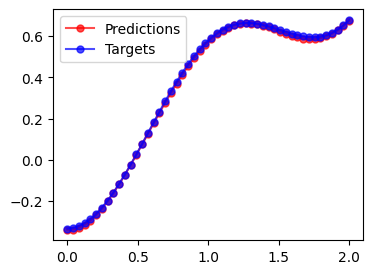

In [11]:
y_pred = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train.detach().numpy(), 
    y_pred.detach().numpy(), 
    marker=".",
    
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x, 
    I,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()

As expected, the solution is good but for a constant value. This is not a problem, because we need to use the model to compute definite integral values as follows:

In [12]:
x_a = torch.tensor(0.2345)
x_b = torch.tensor(1.8)

print(
    "Def integral exact:", 
    definite_integral(x_a, x_b)
)
print(
    "Approx integral:", 
     (model(x_b) - model(x_a)).squeeze().detach().numpy()
)

Def integral exact: tensor(0.8389)
Approx integral: 0.8372756057785695
